In [1]:
import pandas as pd
import os
import sys

import yaml
import logging
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.layers import Dense , Dropout , Flatten , Activation , BatchNormalization , Input , Embedding , Dot
from keras.models import Sequential
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping , ModelCheckpoint  , LearningRateScheduler , TensorBoard , CSVLogger
%matplotlib inline


READING CSV

In [2]:
anime_df = pd.read_csv(r"D:\anime_recommend_mlops\archive\animelist.csv" , low_memory=True ,nrows = 50000000 ,  usecols=["user_id","anime_id","rating"] , dtype={'user_id': 'int32', 'anime_id': 'int32', 'rating': 'int8'})

In [3]:
anime_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [4]:
len(anime_df)

50000000

DATA PROCESSING

In [5]:
n_rating = anime_df['user_id'].value_counts().sort_index()

In [6]:
n_rating

user_id
0          74
1         139
2         494
3         358
4         156
         ... 
162164    284
162165    128
162166    241
162168    145
162169    339
Name: count, Length: 149419, dtype: int64

In [7]:
anime_df = anime_df[anime_df["user_id"].isin(n_rating[n_rating >=400].index)].copy()

In [8]:
len(anime_df)

32651275

In [9]:
min_rating = min(anime_df['rating'])

In [10]:
max_rating = max(anime_df['rating'])

In [11]:
min_rating

0

In [12]:
max_rating

10

In [13]:
avg_rating = np.mean(anime_df['rating'])

In [14]:
avg_rating

np.float64(4.033823640883855)

FEATURE SCALING

In [15]:
anime_df["rating"] = anime_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(float)

In [16]:
avg_rating = np.mean(anime_df['rating'])

In [17]:
avg_rating

np.float64(0.4033823640883852)

In [18]:
anime_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [19]:
anime_df.duplicated().sum()

np.int64(1)

In [20]:
user_ids = anime_df['user_id'].unique().tolist()
print(user_ids)

[2, 6, 12, 16, 17, 19, 21, 41, 42, 44, 47, 53, 55, 60, 66, 73, 74, 85, 89, 90, 94, 98, 102, 108, 111, 112, 120, 121, 122, 135, 145, 146, 147, 153, 155, 156, 172, 174, 184, 190, 193, 194, 198, 204, 205, 209, 214, 219, 222, 227, 228, 235, 238, 240, 243, 248, 251, 252, 257, 264, 267, 272, 274, 275, 284, 285, 286, 290, 291, 293, 300, 301, 306, 308, 310, 313, 314, 316, 320, 321, 324, 325, 326, 327, 330, 336, 340, 345, 346, 349, 350, 366, 367, 371, 372, 375, 381, 382, 386, 389, 398, 405, 406, 413, 414, 418, 423, 426, 428, 431, 432, 436, 437, 438, 440, 442, 444, 445, 446, 455, 457, 459, 464, 467, 468, 469, 478, 481, 483, 484, 486, 493, 498, 500, 516, 517, 519, 524, 526, 529, 531, 538, 542, 547, 549, 559, 563, 564, 566, 569, 571, 577, 590, 593, 596, 601, 603, 608, 613, 614, 617, 620, 629, 631, 639, 642, 643, 644, 649, 652, 655, 656, 662, 664, 673, 674, 680, 681, 683, 686, 689, 694, 699, 711, 713, 714, 716, 719, 725, 728, 730, 731, 732, 734, 745, 746, 748, 753, 760, 764, 770, 774, 776, 778, 779

In [21]:
user2user_encoded = {x:i for i , x in enumerate(user_ids)}

In [22]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [23]:
user2user_decoded = { i : x for x , i in enumerate(user_ids)}

In [24]:
user2user_decoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [25]:
n_users = len(user2user_decoded)

In [26]:
anime_df["user"] = anime_df["user_id"].map(user2user_encoded)

In [27]:
anime_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [28]:
anime_ids = anime_df['anime_id'].unique().tolist()

In [29]:
anime2anime_encoded = { x : i for i , x in enumerate(anime_ids)}

In [30]:
anime2anime_decoded = { i:x for x , i in enumerate(anime_ids)}

In [31]:
n_anime = len(anime2anime_decoded)

In [32]:
anime_df["anime"] = anime_df["anime_id"].map(anime2anime_encoded)

In [33]:
anime_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [34]:
anime_df = anime_df.sample(frac=1 , random_state=43).reset_index(drop=True)

SPLITING DATA

In [35]:
X = anime_df[["user","anime"]].values
y = anime_df["rating"]

In [36]:
test_size = 1000
train_indices = anime_df.shape[0]-test_size

In [37]:
X_train, X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [38]:
len(X)

32651275

In [39]:
len(X_test)

1000

In [40]:
X_train_array= [X_train[:,0] , X_train[:,1]]
X_test_array = [X_test[:,0] , X_test[:,1]]

MODEL ARCHITECHTURE

In [41]:
def Recommender():
    embedding_size = 128

    user = Input(name="user", shape=[1])
    user_embedding = Embedding(
        name="user_embedding",   # FIXED
        input_dim=n_users,
        output_dim=embedding_size
    )(user)

    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(
        name="anime_embedding",  # FIXED
        input_dim=n_anime,
        output_dim=embedding_size
    )(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)(
        [user_embedding, anime_embedding]
    )
    x = Flatten()(x)
    x = Dense(1, kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(
        loss="binary_crossentropy",
        metrics=["mae", "mse"],
        optimizer="Adam"
    )

    return model


In [42]:
model = Recommender()

In [43]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  5,369,088 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,247,424 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,616,518 (29.05 MB)

 Trainable params: 7,616,516 (29.05 MB)

 Non-trainable params: 2 (8.00 B)

In [44]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epoch = 5
sustain_epoch = 0 
exp_decay = 0.8

def lr_fn(epoch):
    if epoch<ramup_epoch:
        return (max_lr-start_lr)/ramup_epoch*epoch +start_lr

    elif epoch  < ramup_epoch+sustain_epoch:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay **(epoch-ramup_epoch-sustain_epoch)+min_lr

In [45]:
lr_callback = LearningRateScheduler( lambda epoch: lr_fn(epoch) , verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint( filepath = checkpoint_filepath , save_weights_only = True , monitor = "val_loss" , mode="min" , save_best_only=True)
early_stopping = EarlyStopping(patience=3 , monitor="val_loss" , mode="min" , restore_best_weights=True)



In [46]:
my_callbacks = [lr_callback , model_checkpoint , early_stopping]

In [47]:
history = model.fit(
    x = X_train_array,
    y = y_train , 
    batch_size = batch_size , 
    epochs = 5 , 
    verbose = 1 , 
    validation_data = (X_test_array , y_test) , 
    callbacks = my_callbacks
)

Epoch 1/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 506s 151ms/step - loss: 0.7986 - mae: 0.3842 - mse: 0.1986 - val_loss: 0.7900 - val_mae: 0.3811 - val_mse: 0.1924 - learning_rate: 1.0000e-05
Epoch 2/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 502s 153ms/step - loss: 0.7809 - mae: 0.3796 - mse: 0.1920 - val_loss: 0.7737 - val_mae: 0.3780 - val_mse: 0.1864 - learning_rate: 1.8000e-05
Epoch 3/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 501s 152ms/step - loss: 0.7404 - mae: 0.3649 - mse: 0.1756 - val_loss: 0.7121 - val_mae: 0.3515 - val_mse: 0.1603 - learning_rate: 2.6000e-05
Epoch 4/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 489s 149ms/step - loss: 0.6330 - mae: 0.3111 - mse: 0.1291 - val_loss: 0.6069 - val_mae: 0.2917 - val_mse: 0.1142 - learning_rate: 3.4000e-05
Epoch 5/5
3266/3266 ━━━━━━━━━━━━━━━━━━━━ 495s 151ms/step - loss: 0.5716 - mae: 0.2731 - mse: 0.1024 - val_loss: 0.5705 - val_mae: 0.2649 - val_mse: 0.0990 - learning_rate: 4.2000e-05


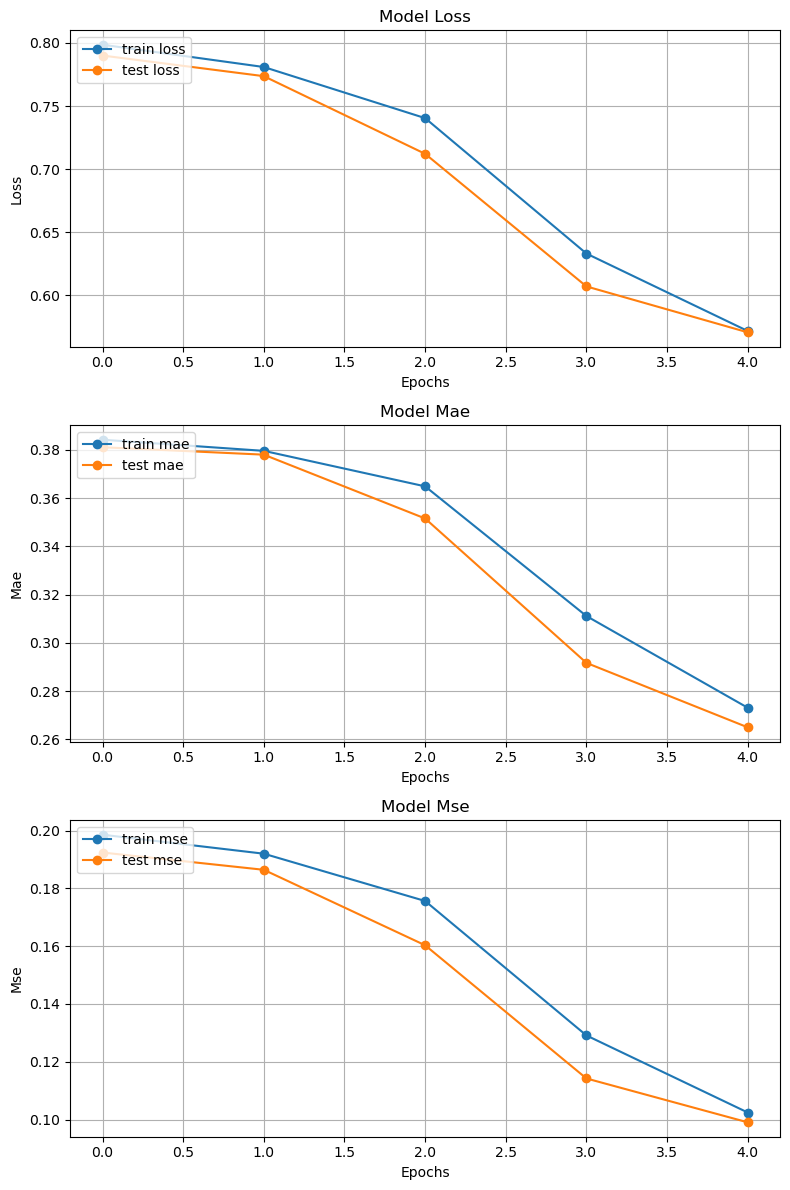

In [50]:
# metrics = ["loss" , "mae" , "mse"]
# fig , axes = plt.subplots(len(metrics) , 1 , figsize = (8 , len(metrics)*4))

# for i , metrics in enumerate(metrics):
#     ax = axes[i]
#     ax.plot(history.history[metrics][0:-2] , marker = "o" , label=f"train{metrics}")
#     ax.plot(history.history[f"val_{metrics}"][0:-2] , marker="o" , label=f"test {metrics}")
#     ax.set_title(f"Model{metrics.capitalize()}")
#     ax.set_ylabel(metrics.capitalize())
#     ax.set_xlabel("Epochs")
#     ax.legend(loc = "upper left")
#     ax.grid(True)

# plt.tight_layout()
# plt.show()


metrics = ["loss", "mae", "mse"]
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics)*4))

for i, metric in enumerate(metrics):   # ← renamed to 'metric'
    ax = axes[i]
    ax.plot(history.history[metric], marker="o", label=f"train {metric}")   # ← removed [0:-2]
    ax.plot(history.history[f"val_{metric}"], marker="o", label=f"test {metric}")  # ← same
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epochs")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [52]:
def extract_weight(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [53]:
anime_weights = extract_weight("anime_embedding" , model)

In [54]:
user_weights = extract_weight("user_embedding" , model)

READING ANIME.CSV

In [55]:
df = pd.read_csv (r"D:\anime_recommend_mlops\archive\anime.csv")

In [56]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [57]:
df = df.replace("Unknown" , np.nan)

In [58]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]

    except:
        print("Error")

    return name

In [59]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]

In [60]:
df["eng_version"] = df.anime_id.apply(lambda x : getAnimeName(x))

In [61]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [62]:
getAnimeName(67)

'Basilisk'

In [63]:
getAnimeName(6702)

'Fairy Tail'

In [64]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [65]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [66]:
df = df[["anime_id" , "eng_version" , "Score", "Genres" , "Episodes" , "Type" , "Premiered" , "Members"]]

In [67]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [122]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        result = df[df.anime_id == anime]
        return result if len(result) > 0 else pd.DataFrame()   # ← return empty DF, not None
    if isinstance(anime, str):
        result = df[df.eng_version == anime]
        return result if len(result) > 0 else pd.DataFrame()
    return pd.DataFrame()   # ← default fallback

In [123]:
getAnimeFrame( 40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


ANIME WITH SYNOPSIS

In [124]:
cols = ["MAIL_ID" , "Name" , "Genres" , "sypnopsis"]

In [125]:
sypnopsis_df = pd.read_csv(r"D:\anime_recommend_mlops\archive\anime_with_synopsis.csv")

In [126]:
sypnopsis_df.head()

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon S

In [127]:
def getSypnopsis(anime, df):
    if isinstance(anime, int):
        result = sypnopsis_df[sypnopsis_df.MAL_ID == anime]
        if len(result) == 0:
            return "N/A"           # ← handle empty result
        return result.sypnopsis.values[0]
    if isinstance(anime, str):
        result = sypnopsis_df[sypnopsis_df.eng_version == anime]
        if len(result) == 0:
            return "N/A"
        return result.sypnopsis.values[0]

In [128]:
getSypnopsis( 40028 , df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

CONTENT/ITEM BASED RECOMMENDATION

In [129]:
pd.set_option("max_colwidth", None)

In [130]:
def find_similar_animes(name , anime_weights , anime2anime_encoded , anime2anime_decoded , df , sypnopsis_df   , n = 10 , return_dist = False , neg=False):
    try:
        index=getAnimeFrame( name , df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        weights = anime_weights
        dists = np.dot(weights , weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            
        print(f"Anime closest to {name}")

        if return_dist:
            return dists , closest 

        SimilarityArr = []
        for i in closest:
            
            decoded_index = anime2anime_decoded.get(i)
            if decoded_index is None:        
                continue
            sypnopsis = getSypnopsis(decoded_index , sypnopsis_df)
            anime_frame = getAnimeFrame(decoded_index , df)
                
            if len(anime_frame) == 0:         # ← skip if anime not found in df
                continue
    

            anime_name = anime_frame.eng_version.values[0]
            
            genre = anime_frame["Genres"].values[0]

            similarity = dists[i]

            SimilarityArr.append({
                "anime_id" : decoded_index,
                "anime_name" : anime_name,
                "genre" : genre,
                "similarity" : similarity,
                "sypnopsis" : sypnopsis
            })           

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity" , ascending=False)
            
        return Frame[Frame.anime_id != index].drop(["anime_id"] , axis =1 )

    except Exception as e:
        print(e)


In [131]:
find_similar_animes("Steins;Gate" , anime_weights , anime2anime_encoded , anime2anime_decoded , df , sypnopsis_df  )

Anime closest to Steins;Gate


,anime_name,genre,similarity,sypnopsis
5,Gash Bell The 1st Movie:Unlisted Demon,"Adventure, Shounen, Supernatural",0.930517,"During the Summer holidays, Gash and gang decide to head for Fuji Mountain for a picnic gathering. There, they encounter a girl with a white magical book. Her name is Kotoha and her book has a message saying that Gash's mother is located a cave in the forest. However, when they eventually found the cave, there was already a blond-haired youth by the name of Wiseman. In order to rescue Wiseman, Gash and the others attempt to proceed into the depths of the cave and stumble upon the entrance to another world. Soon later, the strongest warrior, the Black Knight, appeared before them. Thinking that Gash was the one who stole the 101th magical book, the Black Knight started to attack them. Gash and Kiyomaro have to find the real criminal in exactly 24 hours, or else they will be stuck in the alternative world forever."
4,Tanoshii Muumin Ikka,"Adventure, Comedy, Fantasy, Kids, Slice of Life",0.927434,"Spring has finally arrived in Moomin Valley, giving way to another great adventure for Moomintroll and the rest of its inhabitants. With Snufkin coming home from his winter migration, the locals of the valley finally begin to rise from their hibernation. Finding a mysterious hat, the Moomins cannot bring themselves to throw it away due to its fine quality, instead hoping to eventually find its owner. While playing games with his friends, Moomin tries to hide in the silk hat. When his friends come looking for him, they are shocked to discover that Moomin has transformed into a hideous creature. Examining himself in the mirror, he is disgusted to find himself completely unrecognizable. Transforming back to normal after scaring his friends and family, Moomin and Snufkin decide to toss the hat in the river. As it drifts away, they begin to wonder who the hat belonged to and whether its owner will return for their lost possession."
3,Rhea Gall Force,"Action, Military, Sci-Fi, Mecha",0.925892,"The Solnoid race is long dead, annihilated along with their enemies in the final battle at Sigma Narse. But their descendants survive on Earth, and have now inherited the sad destiny predicted so many years before. The year is 2085. The third world war between East and West has reduced the cities of Earth to mountains of rubble. The mechanical killing machines created by both sides now ruthlessly hunt down the remnants of humanity. Old hatreds between human factions prevent an effective resistance, and the only hope for survival rests in a desperate plan: evacuate the survivors to Mars Base. There they can rebuild and plan the liberation of the home world. Among them, one young woman carries the guilt of her father`s hand in the destruction of civilization. Unknown to her, she also carries the key to a possible salvation. As destiny draws new friends and allies to her, a new Gall Force is born to rise up against the coming destruction... (Source: AniDB)"
2,Ayatsuri Haramase DreamNote,Hentai,0.920309,N/A
1,Beck:Mongolian Chop Squad,"Comedy, Drama, Music, Shounen, Slice of Life",0.902625,"Fourteen-year-old Yukio ""Koyuki"" Tanaka is a dispirited young boy with no goals in life. However, this all changes when Koyuki saves a strange-looking dog named Beck from being harassed by a group of local kids. The dog's owner, 16-year-old Ryuusuke ""Ray"" Minami, is an emerging guitarist and the former member of a popular rock band. After Koyuki meets Ray again in a diner, the older boy leads him to his former band's meeting place and dazzles Koyuki with his amazing guitar skills. Slowly becoming interested in the glamour of western rock culture, Koyuki decides to start playing the guitar while helping Ray achieve his dream of leading the ultimate rock band. Together with Ray's younger sister Maho and a few other members, the two boys launch their career into the world of rock by forming a band called BECK. Beck follows the group's struggles an

In [138]:
def find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded, 
                       anime_df, df, sypnopsis_df, anime2anime_decoded, n=10, neg=False):
    try:
        encoded_index = user2user_encoded.get(user_id)
        if encoded_index is None:
            print(f"User {user_id} not found!")
            return

        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1

        closest_users = sorted_dists[:n] if neg else sorted_dists[-n:]

        print(f"Recommended Animes for User {user_id}")

        SimilarityArr = []
        for i in closest_users:
            decoded_user = user2user_decoded.get(i)
            if decoded_user is None or decoded_user == user_id:
                continue

            similar_user_animes = anime_df[anime_df["user"] == i].sort_values("rating", ascending=False)

            for _, row in similar_user_animes.head(5).iterrows():
                decoded_anime_id = anime2anime_decoded.get(row["anime"])  # ← defined here
                if decoded_anime_id is None:
                    continue

                anime_frame = getAnimeFrame(decoded_anime_id, df)
                if anime_frame is None or len(anime_frame) == 0:
                    continue

                anime_name = anime_frame.eng_version.values[0]
                sypnopsis  = getSypnopsis(decoded_anime_id, sypnopsis_df)
                genre      = anime_frame["Genres"].values[0]

                SimilarityArr.append({
                    "anime_id"   : decoded_anime_id,   # ← now safely defined
                    "anime_name" : anime_name,
                    "genre"      : genre,
                    "score"      : row["rating"],
                    "sypnopsis"  : sypnopsis
                })

        if not SimilarityArr:
            print("No recommendations found.")
            return pd.DataFrame()

        Frame = (pd.DataFrame(SimilarityArr)
                   .drop_duplicates("anime_name")
                   .sort_values("score", ascending=False)
                   .reset_index(drop=True))

        return Frame.drop(["anime_id"], axis=1)

    except Exception as e:
        print(e)

In [139]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded,
                   anime_df, df, sypnopsis_df, anime2anime_decoded, n=10)

Recommended Animes for User 11880


,anime_name,genre,score,sypnopsis
0,Muka Muka Paradise,"Adventure, Comedy",1.0,"Uiba Shikatani, the daughter of a pet shop owner, is heartbroken after some reptile eggs fail to hatch. In his attempts to cheer her up, her father brings home a large, striped egg, which he hopes will successfully hatch (unexpectedly into a green dinosaur whom they call ""Muka-Muka,"" which are the only words which the baby reptile can speak). Muka-Muka soon becomes the talk of the town and comes into the interest of the town's professor and his wacky inventions, including a time machine which successfully teleports the Shikatani's among other families and their homes to pre-historic times where they encounter several other dinosaurs and enchanted beings on their adventures. (Source: ANN)"
1,Doraemon: Time Machine de Oshougatsu,"Sci-Fi, Adventure, Comedy, Kids, Shounen",1.0,No synopsis information has been added to this title. Help improve our database by adding a synopsis here .
2,Gakuen Saimin Reido,Hentai,1.0,N/A
3,Otaku no Video,"Comedy, Drama, Historical, Magic, Mecha, Sci-Fi",1.0,"Somewhat based on the real story of how Gainax was founded, Otaku no Video addresses all aspects of an otaku lifestyle. Ken Kubo is a young man living an average life until he is dragged into a group of otaku. Slowly, he becomes more like them until he decides to abandon his former life to become king of otaku—the otaking! Mixed in are live-action interviews with real otaku, addressing every aspect of hardcore otaku life. Not only are anime and manga fans included, but also sci-fi fans, military fans, and other groups of Japanese geeks."
4,OZ,"Action, Military, Sci-Fi, Drama, Shoujo",1.0,"oosely based on L.F. Baum's novel, The Wizard of Oz. Original manga done by Itsuki Natsumi. A nuclear war has killed most of humanity and split the USA into six warring states. By 2021, a legend has grown up about the fabled city of OZ where everything still works. Scientist Felicia sets out in search of it with the mercenary Muto and android 1019. At the end of the quest they only discover a military base and a madman. A mercenary was hired by a girl to bring her to the mythical Oz (a paradise) where her missing brother supposedly lived. Accompanying them was a cyborg sent by her brother. But Oz was not the paradise it seemed and her brother was not as sane as he was smart. (Source: AniDB)"
5,Tensai Bakabon,"Slice of Life, Comedy",1.0,"Tensai Bakabon is the tale of a child prodigy and his ""philosophical"" father. Bakabon‘s father has his own philosophy and he leaves no stone unturned in his quest for answers. Despite his ability to trouble Trouble, for some reason, Papa Bakabon is regarded as ""The Great Philosopher,"" and is sought after for advice, which of course ends up in disastrous results. Tensai Bakabon joins his father in his philosophical quests which drives the people in their town crazy. (Source: Animation Xpress)"
6,Nikuyoku Gangu Takuhainin,Hentai,1.0,N/A
7,Legend of Crystania:The Motion Picture,"Action, Adventure, Fantasy, Magic, Supernatural",1.0,"shram, desperate to find a home for his people, is tricked into selling his soul. 300 years later, Pirotesse's devotion to her king remains unshaken. In the sacred world of Crystania, amidst a civil war waged by shape-changing warriors, she searches for her beloved Ashram. She meets Redon, a young prince obsessed with avenging his murdered parents. Together, they confront Ashram's captor -- the bloodthirsty Barbas, who aspires to rule Crystania as ""The God's King"". (Source: ANN)"
8,Samayou Midara na Lunatics,Hentai,1.0,N/A
9,Saint October,"Adventure, Fantasy",1.0,"hether it is the future or the past it is the world of fantasy and horror hiding in the shadow of the demon city. In the city, consecutive mysterious incidents that cannot be solved by science have occurred. To solve the incidents, they gather three girl detectives possessing special abilities. Hayama Kotono. She is an orphan living in a convent. Shirafuji N